Loading the predictor and detector...
 Starting Video 
Video Ended
Distraction level : 3.125 %
AttentionLevel : 96.875 %


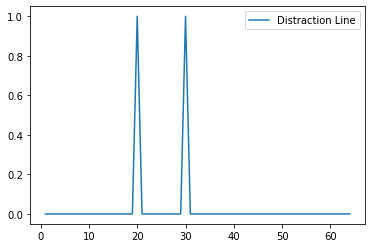

In [37]:

from scipy.spatial import distance as dist
from threading import Thread
import numpy as np
import time
import dlib
import cv2
import os
from imutils import face_utils
import matplotlib.pyplot as plt

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])

    C = dist.euclidean(eye[0], eye[3])

    ear = (A + B) / (2.0 * C)

    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

def rescaleFrame(frame,scale=0.75):
    width=int(frame.shape[1]*scale)
    height=int(frame.shape[0]*scale)
    
    dimensions=(width,height)
    
    return cv2.resize(frame,dimensions,interpolation=cv2.INTER_AREA)



EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 30
YAWN_THRESH = 35
alarm_status = False
alarm_status2 = False
saying = False
COUNTER = 0

print("Loading the predictor and detector...")
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")    
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')


print(" Starting Video ")
# vs = VideoStream(src=args["webcam"]).start()
cap=cv2.VideoCapture(0)
time.sleep(1.0)
pTime = 0
cTime = 0

frameCounter1=0

yCount=0
frameCounterList=[]
DistractionList=[]
while True:

    success,frame = cap.read()
    frame = rescaleFrame(frame,1.1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    yCount+=1
    frameCounterList.append(yCount)
    DistractionList.append(0)
    
    rects = detector.detectMultiScale(gray, scaleFactor=1.1, 
        minNeighbors=5, minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE)

    for (x, y, w, h) in rects:
        rect = dlib.rectangle(int(x), int(y), int(x + w),int(y + h))
        
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        eye = final_ear(shape)
        ear = eye[0]
        leftEye = eye [1]
        rightEye = eye[2]

        distance = lip_distance(shape)

        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (255, 255, 255), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (255, 255, 255), 1)

        lip = shape[48:60]
        cv2.drawContours(frame, [lip], -1, (255, 255, 255), 1)

        if ear < EYE_AR_THRESH:
            COUNTER += 1
            
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                if alarm_status == False:
                    alarm_status = True
                    
                    DistractionList[yCount-1]=1
                    frameCounter1+=1
                cv2.putText(frame, "DROWSINESS ALERT!", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                
        else:
            COUNTER = 0
            alarm_status = False

        if (distance > YAWN_THRESH):
                cv2.putText(frame, "Yawn Alert", (10, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                if alarm_status2 == False and saying == False:
                    alarm_status2 = True
                    DistractionList[yCount-1]=1
                    frameCounter1+=1
        else:
            alarm_status2 = False
        
        cv2.putText(frame, "EAR: {:.2f}".format(ear), (550, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
        cv2.putText(frame, "YAWN: {:.2f}".format(distance), (550, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

           
    cTime=time.time()
    fps=1/(cTime-pTime)
    pTime=cTime
    cv2.putText(frame,str(int(fps)),(10,500),cv2.FONT_HERSHEY_COMPLEX,
              .8,(255,0,0),3)
    
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("d"):
        break
        
cap.release()
cv2.destroyAllWindows()
print("Video Ended")

# x1=x1[:min(len(x1),len(y1),len(y2))]
# y1=y1[:min(len(x1),len(y1),len(y2))]
# y2=y2[:min(len(x1),len(y1),len(y2))]
# plt.plot(x1,y1)

plt.plot(frameCounterList,DistractionList)
plt.legend(["Distraction Line"])

DistractionLevel=(frameCounter1/len(frameCounterList))*100
print("Distraction level : "+str(DistractionLevel) +" %")
print("AttentionLevel : "+ str(100-DistractionLevel)+ " %")